In [1]:
import numpy as np 
import pandas as pd 
import json

trial_dirs=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if(".json" in filename): # only if json (ignore other files)
            trial_dirs.append(os.path.join(dirname, filename))
print(len(trial_dirs))

93


## Loading into the lists

In [2]:
trials=[]
trials_NCTid = []
noDuplic_trial_dirs=[]
for td in trial_dirs:
    f = open(td, "r").read()
    json_f=json.loads(f)
    nctid=json_f["protocolSection"]["identificationModule"]["nctId"]
    if nctid not in trials_NCTid:
        trials_NCTid.append(nctid)
        trials.append(json_f)
        noDuplic_trial_dirs.append(td)
trial_dirs=noDuplic_trial_dirs
print(len(trials))

69


## Filtering lists

In [3]:
removed_items=0
for i in range(len(trials)):
    if(trials[i-removed_items]["hasResults"]==False):
        trials.pop(i-removed_items)
        trials_NCTid.pop(i-removed_items)
        trial_dirs.pop(i-removed_items)
        removed_items+=1
print(len(trials))

60


## Group class

In [4]:
import math
class Group:
    def __init__(self,nctid,trial, indx):
        self.NCTid=nctid
        self.trial = trial
        self.index = indx
        self.group_name= self.trial["resultsSection"]["participantFlowModule"]["groups"][self.index]["title"]
        self.group_desc= self.trial["resultsSection"]["participantFlowModule"]["groups"][self.index]["description"]
        self.dose_unit=None
        self.dose_cells=None
        self.dose_cells_kg=None
        self.target=None
        self.properties={}
    def set_dose(self,doseAmount, doseUnit):
        if(doseAmount==None or doseAmount=="" or math.isnan(doseAmount)): # don't assign anything
            pass
        elif(doseUnit=='cells'):
            self.dose_unit=doseUnit
            self.dose_cells=doseAmount
        elif(doseUnit=='cells/kg'):
            self.dose_unit=doseUnit
            self.dose_cells_kg=doseAmount
        else:
            raise ValueError("Invalid dose unit. Valid units are 'cells' and 'cells/kg'.")
    def set_target(self,targ):
        self.target=targ
    def set_property(self, property_name, property_value):
        self.properties[property_name]=property_value
    def get_property(self, property_name):
        return self.properties[property_name]

In [5]:
# Each trial has one or more groups. Put all groups in an array
groups=[]
for i in range(len(trials)):
    num_of_groups=len(trials[i]["resultsSection"]["participantFlowModule"]["groups"])
    for j in range(num_of_groups):
        new_gr=Group(trials_NCTid[i], trials[i], j)
        groups.append(new_gr)

In [6]:
targets = [
    "CD80",
    "TNFRSF17",
    "CD22",
    "CD19",
    "NY-ESO-1",
    "CD66e",
    "CD27-L",
    "CLDN18",
    "CD137",
    "CD38",
    "DLL3",
    "EPHA2",
    "EGFR",
    "EGFR vIII",
    "EBV LMP1",
    "HER2",
    "GPRC5D",
    "GCPII",
    "GPC3",
    "PMEL",
    "CD34",
    "ICAM1",
    "IL3RA",
    "CD20",
    "TNFRSF8",
    "MAGEA1",
    "MAGEA4",
    "MSLN",
    "MUC1",
    "CD33",
    "CD371",
    "NCAM1",
    "L1CAM",
    "ROR1",
    "ROR2",
    "MME",
    "KLRK1",
    "PD-L1",
    "PROM1",
    "PSCA",
    "MET",
    "CS1",
    "SDC1",
    "CD7",
    "TRBC1",
    "CD4",
    "TRAIL-R2",
    "EPCAM",
    "KIT",
    "BCMA"
]

## Perform quick text mining to guess used targets
It then exports it for manual inspection and to manually find doses.

In [7]:
gr_id=[]
gr_titles=[]
gr_descs=[]
gr_used_targets=[]

for gr in groups:
    gr_id.append(gr.NCTid)
    gr_titles.append(gr.group_name)
    gr_descs.append(gr.group_desc)

for k in range(len(gr_titles)):
    used_target=""
    for t in targets:
        if((t in gr_titles[k]) or (t in gr_descs[k])):
            if(used_target==""):
                used_target=t
            else:
                used_target="multi-target"
        if(used_target==""):
            if(t in str(groups[k].trial)):
                if(used_target==""):
                    used_target=t
                else:
                    used_target="multi-target"
    gr_used_targets.append(used_target)
df=pd.DataFrame({"NCTid": gr_id, "Group_Title": gr_titles, "Group_Description": gr_descs, "Targets": gr_used_targets})
df.to_excel("Groups_Summary.xlsx")

## After manual inspection
Remove rows that don't have info on dose or used target.

In [8]:
labeled_df=pd.read_excel("/kaggle/input/groups-summary-targets-doses/Groups_Summary_Targets_Doses.xlsx")
labeled_df.dropna(subset=["Cells/kg", "Cells"], how='all', inplace=True, ignore_index=True)
labeled_df.dropna(subset="Targets", inplace=True, ignore_index=True)
display(labeled_df)

,NCTid,Group_Title,Group_Description,Targets,Cells/kg,Cells
0,NCT02706392,Cohort A Dose Level 1,"Patients with ROR1+ CLL, MCL or ALL that are r...",ROR1,330000.0,NaN
1,NCT02706392,Cohort A Dose Level 2,"Patients with ROR1+ CLL, MCL or ALL that are r...",ROR1,1000000.0,NaN
2,NCT02706392,Cohort B Dose Level 1,Patients with ROR1+ NSCLC or TNBC who have fai...,ROR1,330000.0,NaN
3,NCT02706392,Cohort B Dose Level 2,Patients with ROR1+ NSCLC or TNBC who have fai...,ROR1,1000000.0,NaN
4,NCT02706392,Cohort B Dose Level 3,Patients with ROR1+ NSCLC or TNBC who have fai...,ROR1,3300000.0,NaN
...,...,...,...,...,...,...
177,NCT03704298,Phase 1: Cohort 3: Axicabtagene Ciloleucel + U...,Participants received cyclophosphamide 500 mg/...,CD19,2000000.0,NaN
178,NCT03704298,Phase 1: Cohort 4: Axicabtagene Ciloleucel + U...,Participants received cyclophosphamide 500 mg/...,CD19,2000000.0,NaN
179,NCT04314843,Phase 1/Cohort 1,Participants received 500 mg/m\^2 cyclophospha...,CD19,2000000.0,NaN
180,NCT04314843,Phase 1/Cohort 2,Participants received 500 mg/m\^2 cyclophospha...,CD19,2000000.0,NaN


## Update groups list
Remove groups that were excluded in manual inspection and add dose and target info.

In [116]:
print(len(groups))

removed_groups=0
for i in range(len(groups)):
    if groups[i-removed_groups].NCTid not in list(labeled_df["NCTid"]):
        groups.pop(i-removed_groups)
        removed_groups+=1
    elif groups[i-removed_groups].group_name not in list(labeled_df.loc[labeled_df['NCTid']==groups[i-removed_groups].NCTid,"Group_Title"]):
        groups.pop(i-removed_groups)
        removed_groups+=1

print(len(groups))

182
182


In [117]:
# Find which targets are represented in the dataset
display(labeled_df["Targets"].value_counts())

Targets
CD19      101
BCMA       32
EGFR       13
CD20       11
VEGFR      11
ROR1        6
SLAMF7      4
PSCA        3
PD-L1       1
Name: count, dtype: int64

In [118]:
targets_col=list(labeled_df["Targets"])
dose_col_kg=list(labeled_df["Cells/kg"])
dose_col_flat=list(labeled_df["Cells"])
for i in range(len(groups)):
    groups[i].set_target(targets_col[i])
    groups[i].set_dose(dose_col_kg[i],"cells/kg")
    groups[i].set_dose(dose_col_flat[i],"cells")
    print(groups[i].dose_unit)

cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells
cells
cells
cells
cells
cells
cells
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells
cells
cells
cells
cells
cells
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells
cells
cells
cells
cells
cells
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells/kg
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
cells
c

## Deaths and adverse events data

In [119]:
deaths=[]
serious=[]
strength=[]
for gr in groups:
    try:
        gr_deaths=float(gr.trial["resultsSection"]["adverseEventsModule"]["eventGroups"][gr.index]["deathsNumAffected"])/float(gr.trial["resultsSection"]["adverseEventsModule"]["eventGroups"][gr.index]["deathsNumAtRisk"])
    except:
        print("Deaths not obtained for study "+gr.NCTid)
        gr_deaths=None
    try:
        gr_serious=float(gr.trial["resultsSection"]["adverseEventsModule"]["eventGroups"][gr.index]["seriousNumAffected"])/float(gr.trial["resultsSection"]["adverseEventsModule"]["eventGroups"][gr.index]["seriousNumAtRisk"])
        
    except:
        print("Serious events not obtained for study "+gr.NCTid)
        gr_deaths=None
    gr.set_property("deaths", gr_deaths)
    deaths.append(gr_deaths)
    gr.set_property("serious_ae", gr_serious)
    serious.append(gr_serious)
    try:
        strength.append(float(gr.trial["resultsSection"]["adverseEventsModule"]["eventGroups"][gr.index]["deathsNumAtRisk"]))
    except:
        strength.append(0)
labeled_df["deaths"]=deaths
labeled_df["serious"]=serious
display(labeled_df)

Deaths not obtained for study NCT01029366
Deaths not obtained for study NCT01029366
Deaths not obtained for study NCT02028455
Serious events not obtained for study NCT02028455
Deaths not obtained for study NCT03049449
Serious events not obtained for study NCT03049449
Deaths not obtained for study NCT03049449
Serious events not obtained for study NCT03049449
Deaths not obtained for study NCT03602612
Serious events not obtained for study NCT03602612


,NCTid,Group_Title,Group_Description,Targets,Cells/kg,Cells,deaths,serious,strengths
0,NCT02706392,Cohort A Dose Level 1,"Patients with ROR1+ CLL, MCL or ALL that are r...",ROR1,330000.0,NaN,0.500000,0.500000,2.0
1,NCT02706392,Cohort A Dose Level 2,"Patients with ROR1+ CLL, MCL or ALL that are r...",ROR1,1000000.0,NaN,0.000000,1.000000,1.0
2,NCT02706392,Cohort B Dose Level 1,Patients with ROR1+ NSCLC or TNBC who have fai...,ROR1,330000.0,NaN,1.000000,0.500000,2.0
3,NCT02706392,Cohort B Dose Level 2,Patients with ROR1+ NSCLC or TNBC who have fai...,ROR1,1000000.0,NaN,0.666667,0.666667,3.0
4,NCT02706392,Cohort B Dose Level 3,Patients with ROR1+ NSCLC or TNBC who have fai...,ROR1,3300000.0,NaN,0.454545,0.909091,11.0
...,...,...,...,...,...,...,...,...,...
177,NCT03704298,Phase 1: Cohort 3: Axicabtagene Ciloleucel + U...,Participants received cyclophosphamide 500 mg/...,CD19,2000000.0,NaN,0.333333,0.333333,3.0
178,NCT03704298,Phase 1: Cohort 4: Axicabtagene Ciloleucel + U...,Participants received cyclophosphamide 500 mg/...,CD19,2000000.0,NaN,0.000000,0.666667,3.0
179,NCT04314843,Phase 1/Cohort 1,Participants received 500 mg/m\^2 cyclophospha...,CD19,2000000.0,NaN,0.666667,0.666667,3.0
180,NCT04314843,Phase 1/Cohort 2,Participants received 500 mg/m\^2 cyclophospha...,CD19,2000000.0,NaN,0.666667,1.000000,3.0


## Checking types of diseases in all trials

In [164]:
diseases=set()
solid_tumors = [
    "Metastatic Prostate Carcinoma",
    "Stage IV Lung Non-Small Cell Cancer AJCC v7",
    "Metastatic Lung Non-Small Cell Carcinoma",
    "Stage IIIA Lung Non-Small Cell Cancer AJCC v7",
    "Stage IVA Prostate Cancer AJCC v8",
    "Metastatic Triple-Negative Breast Carcinoma",
    "Stage IVB Prostate Cancer AJCC v8",
    "Malignant Glioma",
    "Stage IV Breast Cancer AJCC v6 and v7",
    "Metastatic Cancer",
    "Glioblastoma",
    "Unresectable Lung Non-Small Cell Carcinoma",
    "Gliosarcoma",
    "Advanced Lung Cancer",
    "Brain Cancer",
    "Castration-Resistant Prostate Carcinoma",
    "Renal Cancer",
    "Malignant Solid Neoplasm",
    "Stage IIIB Lung Non-Small Cell Cancer AJCC v7",
    "Stage IV Prostate Cancer AJCC v8"
]
markers=[]
for gr in groups:
    diseases.update(gr.trial["protocolSection"]["conditionsModule"]["conditions"])
    for st in solid_tumors:
        if st in gr.trial["protocolSection"]["conditionsModule"]["conditions"]:
            markers.append('v')
        else:
            markers.append('o')
        break
            
for d in list(diseases):
    print(d)

labeled_df["markers"]=markers
print(markers)

CD19+ Acute Leukemia
Metastatic Prostate Carcinoma
Diffuse, Large B-cell Lymphoma
Stage III Chronic Lymphocytic Leukemia
Stage IV Grade 2 Follicular Lymphoma
Relapsed/Refractory B-precursor Acute Lymphoblastic Leukemia
Lymphatic Diseases
Myeloma-Multiple
Stage IV Lung Non-Small Cell Cancer AJCC v7
Metastatic Lung Non-Small Cell Carcinoma
Non-Hodgkins Lymphoma (NHL) Patients, With CD19+B Cell Lymphomas
Lymphoma, Non-hodgkins
Neoplasms by Histologic Type
Refractory Diffuse Large B Cell Lymphoma (DLBCL)
Recurrent Grade 3 Follicular Lymphoma
Recurrent Small Lymphocytic Lymphoma
Chronic Lymphocytic Leukemia
Adult Acute Lymphoblastic Leukemia in Remission
Stage IIIA Lung Non-Small Cell Cancer AJCC v7
Stage IV Grade 1 Follicular Lymphoma
Stage III Grade 3 Follicular Lymphoma
Immune System Disorder
Refractory Plasma Cell Myeloma
Stage IV Adult Diffuse Large Cell Lymphoma
Immunoproliferative Disorders
Malignant Glioma
Stage IV Chronic Lymphocytic Leukemia
Recurrent Grade 2 Follicular Lymphoma
S

ValueError: Unrecognized marker style ['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']

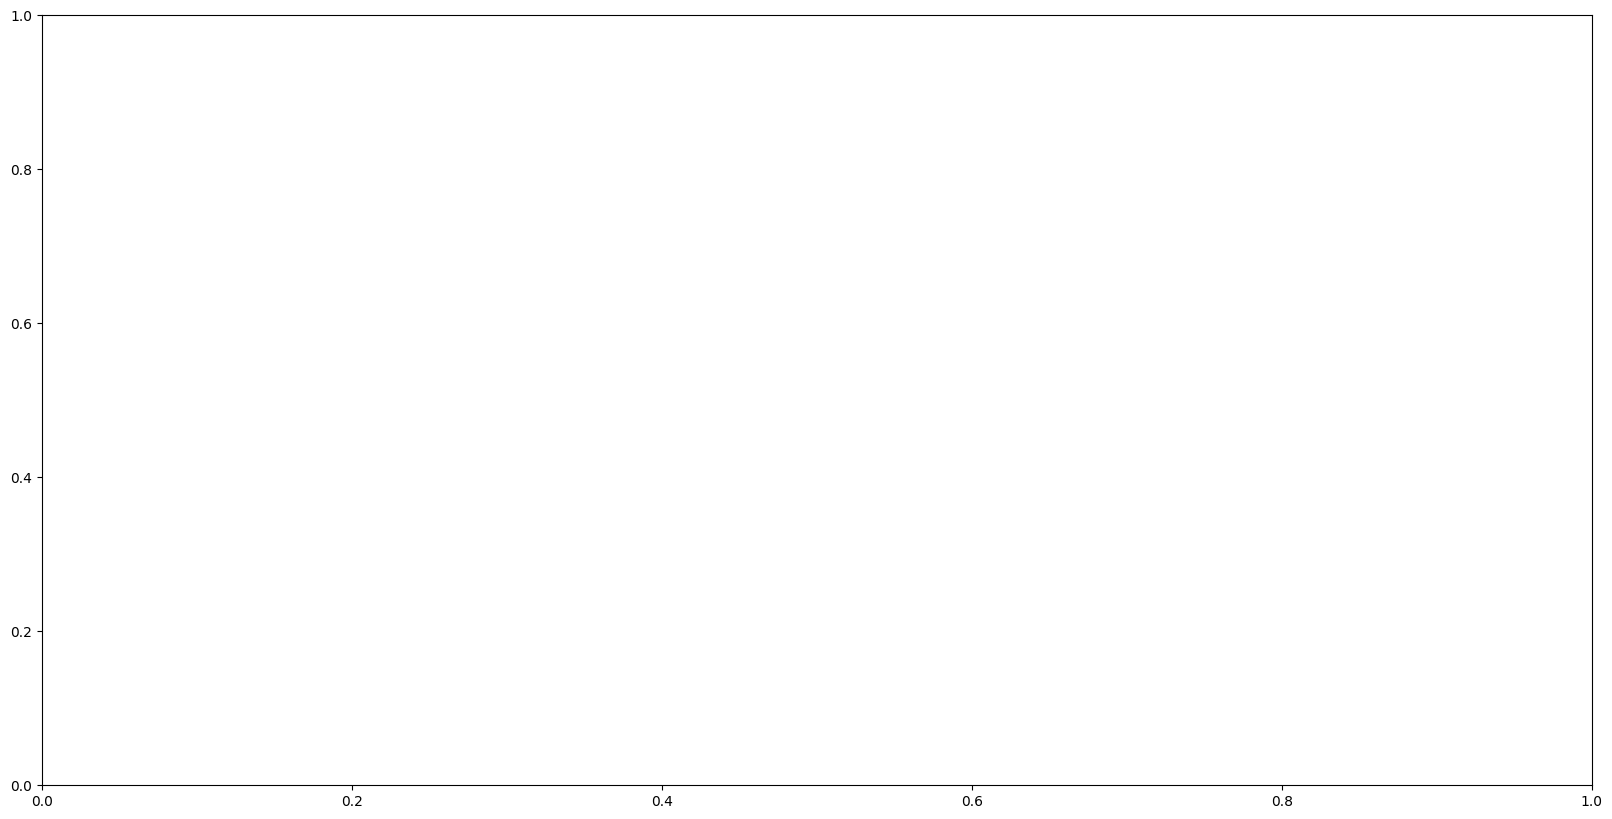

In [162]:
import matplotlib.pyplot as plt
import numpy as np

metric="serious"
units="Cells/kg"
target_of_interest="BCMA"
approximate_to_flatdose=True
avg_weight=65

#labeled_df["strengths"]=((np.max(strength)-np.array(strength))/(np.max(strength)-np.min(strength)))
labeled_df["strengths"]=strength
# Print statements for debugging
if(approximate_to_flatdose==False):
    labeled_df_filtered = labeled_df.dropna(subset=[units])  # Ensure "Cells/kg" is a list
else:
    labeled_df_filtered=labeled_df.copy()
    units="Cells"
labeled_df_filtered = labeled_df_filtered[labeled_df_filtered["Targets"] == target_of_interest]
#labeled_df_filtered = labeled_df_filtered[labeled_df_filtered["Cells/kg"] < 1000000000.0]

# Assign data to x and y
y = labeled_df_filtered[metric].values  # Use .values to get numpy array
if(approximate_to_flatdose==True):
    approx_flat=labeled_df_filtered["Cells/kg"].mul(avg_weight).fillna(0)
    x=labeled_df_filtered["Cells"].fillna(0).add(approx_flat)
else:
    x = labeled_df_filtered[units].values  # Use .values to get numpy array
plt.figure(figsize=(20,10))
plt.scatter(x, y, alpha=0.5, c=labeled_df_filtered["strengths"], cmap='Oranges', vmax=20, marker=list(labeled_df_filtered["markers"]))  # Use alpha for transparency if needed
#plt.yscale('log')
plt.xscale('log')
aprox=""
if(approximate_to_flatdose==True):
    aprox=", approximated to flat dose"
plt.title(metric+" in trials of "+target_of_interest+aprox)
plt.xlabel("dose ["+units+"]")
plt.ylabel("fraction")
'''def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # No labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    print("D")
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.5)  # Use alpha for transparency if needed
    
    # Determine nice limits
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, edgecolor='black')
    ax_histy.hist(y, bins=bins, orientation='horizontal', edgecolor='black')

# Start with a square Figure
fig = plt.figure(figsize=(6, 6))

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal Axes and the main Axes in both directions.
# Adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals
scatter_hist(x, y, ax, ax_histx, ax_histy)'''
plt.colorbar(label="Num of participants in group")
plt.show()


In [125]:
len(y)

101

## Confirming that they all used lymphodepletion

In [152]:
ctr=0
lymphodepletion_keywords=[
    "Cyclophosphamide",
    "Ifosfamide",
    "Melphalan",
    "Fludarabine",
    "Cladribine",
    "Methotrexate",
    "Alemtuzumab",
    "Rituximab",
    "Dexamethasone",
    "Prednisone",
    "Etoposide",
    "Bendamustine",
    "Temozolomide",
    'chemotherapy',
    'lymphodeplet'
]
for gr in groups:
    for word in lymphodepletion_keywords:
        if word in str(gr.trial["protocolSection"]):
            ctr+=1
            break
print(len(groups))
print(ctr)

182
181


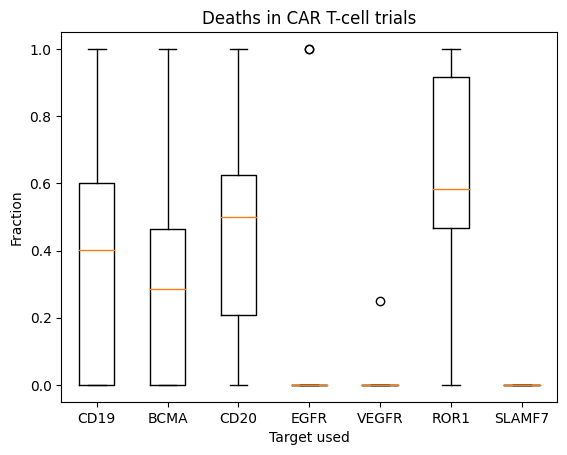

In [92]:
labeled_df_filtered2 = labeled_df.dropna(subset=["deaths"])
plt.boxplot([labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="CD19", "deaths"],labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="BCMA", "deaths"],labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="CD20", "deaths"],labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="EGFR", "deaths"],labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="VEGFR", "deaths"],labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="ROR1", "deaths"],labeled_df_filtered2.loc[labeled_df_filtered2["Targets"]=="SLAMF7", "deaths"]])
plt.title("Deaths in CAR T-cell trials")
plt.ylabel("Fraction")
plt.xlabel("Target used")
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7], labels=["CD19", "BCMA", "CD20", "EGFR", "VEGFR", "ROR1", "SLAMF7"])
plt.show()